In [1]:
from functions import *
from math import pi
import warnings
warnings.filterwarnings('ignore')

# USER TRANSMITTER

## INTRODUCTION

The aim of the project is to simulate the transmission of a sequence of messages, transmitted by a user placed on the surface of the Moon and received by a satellite in orbit. The signal at the receiver is sampled in I/Q samples, that are quantized and then written inside a binary file.

The messages to transmit are either ACKs or NACKs and the signals associated to each packet is obtained by using the Binary Offset Carrier BOC(1,1) modulation.
The software simulates the propagation through the channel by introducing an attenuation in the transmitted signal and a delay due to the propagation. The noise, that is supposed to be AWGN, is included directly in the I/Q samples, before the quantization.

## LOADING ALL THE FILES

The first thing to do is loading all the files that contain the parameters used for the software: the settings.ini file, the N_ACK.csv file (that contains the messages that are supposed to be ACKed or NACKed) and the output of the orbit propagator group, that contains the oribt information.

In [2]:
f = open('settings.ini')
settings = json.load(f)
 
for i in settings:
    print(i, end=': ')
    print(settings[i])
    
f.close()

#the transmitted power is in Watt, while the transmitter and receiver gains are in dB, as well as the SNR

fSampling: 4092000.0
quantizationBits: 16
scenarioDuration: 5.05
SV_PRN_ID: 1
CRCpolynomial: A23DCB
SYNCpattern: 0101100000
TAILpattern: 000000
SVIDlength: 6
MIDlength: 4
MBODYlength_TX: 80
MBODYlength_ACK: 30
CRClength: 24
nPRN_x_Symbol: 1
nChip_x_PRN: 4092
chipRate: 1023000.0
bitRate: 250
maxDoppler: 100000.0
transmitterGain: 30
receiverGain: 15
transmittedPower: 27
SNR: 15


In [3]:
#reading the file with the packets to transmit: if GOOD = 1, it's an ACK, if GOOD = 0 it's a NACK
acks = pd.read_csv("N_ACK.csv")
num_packets = acks.shape[0]
print("Packets to transmit: ", num_packets)
acks

Packets to transmit:  5


,MSGID,GOOD
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


Now we need to create the messages, and we store them into a matrix. Each row of the matrix corresponds to a message.

In [4]:
#we create the empty matrix that will contain all the packets (each row of the matrix is a packet). Each packet
#has a length of 80 bits
packets_matrix = np.zeros(shape=(num_packets, 80), dtype=np.uint8)
# print(packets_matrix)

#each row of the file is added to a list called N_ACK. Based on the value of the GOOD column, either a ACK or 
#a NACK is generated, by using the function createMessageAck (or createMessageNack), defined inside the functions
#file

f = open('N_ACK.csv')
csv_file = csv.reader(f)
N_ACK = []
for row in csv_file:
        N_ACK.append(row)
        
for i in range(len(N_ACK)-1):
    if(N_ACK[i+1][1]=='1'):
        msg=createMessageACK(settings['SYNCpattern'],settings['SV_PRN_ID'],int(N_ACK[i+1][0]))
    if(N_ACK[i+1][1]=='0'):
        msg=createMessageNACK(settings['SYNCpattern'],settings['SV_PRN_ID'],int(N_ACK[i+1][0]))
    packets_matrix[i] = msg

print("\nMatrix of packets:")
print(packets_matrix)


Matrix of packets:
[[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0
  1 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0
  0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1
  0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1
  0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1
  1 1 0 0 0 0 0 0]]


In [5]:
filename = "E1B - Gal.txt"

# defining the name of the column of the dataframe called e1b
columns = ["Hexadecimal"]

#reading the file
e1b = pd.read_table(filename, sep='\n', header=None, names=columns)

# deleting the first 15 characters (not part of the code)
e1b['Hexadecimal'] = [el[16::] for el in e1b['Hexadecimal']]

# creating a new column with the codes indexes and placing it as first column
e1b['Code index'] = np.arange(1,51,1)
column_list = ["Code index", "Hexadecimal"]
e1b = e1b.reindex(columns=column_list)

# printing the first lines of the dataframe
e1b.head()

,Code index,Hexadecimal
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...


In [6]:
# creation of a new column of the dataframe with the binary representation of each PRN
e1b['Binary'] = e1b['Hexadecimal'].apply(hex2bin)

#creation of a copy of the dataframe to use without modifying the original dataframe
e1bcopy = e1b.copy()
e1b.head()

,Code index,Hexadecimal,Binary
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ..."


In [7]:
# to verify if the conversion was successful, we print the last code in binary:

# since the last code starts with 9 7 ... in hexadecimal, the binary representation should start with 
# 1001 0111 ...
# and since it ends with ... 2 0, the binary representation should end with
# ... 0010 0000

print("First 8 bits: ", e1b['Binary'][49][0:8])    
print("Last 8 bits: ", e1b['Binary'][49][-8:])    

First 8 bits:  [1 0 0 1 0 1 1 1]
Last 8 bits:  [0 0 1 0 0 0 0 0]


To obtain the BOC(1,1) modulation we need first to modify the PRNs, as explained in the report, in order to obtain values equal to 1 and -1 (and not 1 and 0 as before). This is done by adding a new column to the dataframe. The conversion is done by the corresponding function (see functions file).

In [8]:
#we create different dataframes to avoid any modification of the original ones
e1bmodified = e1b.copy()
e1bmodified['Modified'] = e1bmodified['Binary'].apply(conversion)

e1bmodifiedcopy = e1bmodified.copy()
e1bmodified.head()

,Code index,Hexadecimal,Binary,Modified
0,1,F5D710130573541B9DBD4FD9E9B20A0D59D144C54BC793...,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, ...","[-1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, ..."
1,2,96B856A629F581D1344FEF597835FE60434625D077ECF0...,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, ...","[-1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1..."
2,3,E57DE19A3E4A8C122FCB1DD6584B3D2DAE364D800F9C5A...,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[-1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -..."
3,4,C0FC4C72A12023BA7093C86775DF3D2F42C7CEDE616876...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...","[-1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1,..."
4,5,EA9596357B343DFC31D5875CC0E94117A33651472E476D...,"[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, ...","[-1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1,..."


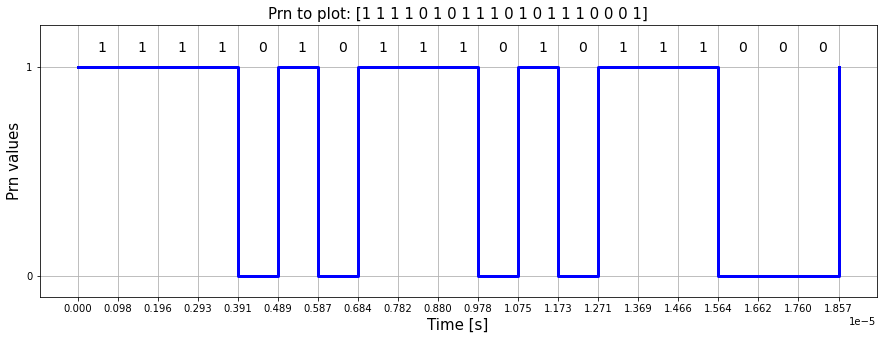

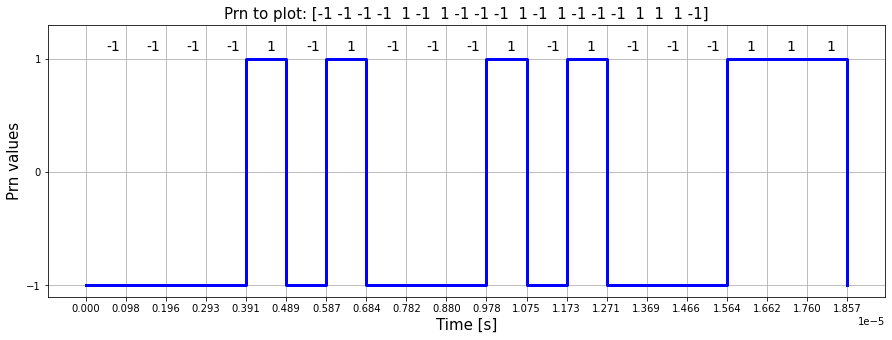

In [9]:
#this is a plot of the first 20 chips of the first PRN in the dataframe, just to visualize it as a signal
plot_prn_zeros(20, e1bcopy['Binary'][0], settings['chipRate'])

#this is a plot to show the same PRN after the conversion
plot_prn_modified(20, e1bmodifiedcopy['Modified'][0], settings['chipRate'])

## BOC(1,1) MODULATION

As explained in the report, the BOC(1,1) modulation is obtained by multiplying the data message (with symbol period $T_b$), the PRN sequence (with chip period $T_c$) and a NRZ subcarrier with period $T_p = T_c$. The multiplication by the sinusoidal carrier is not needed, since we are supposed to work in baseband.

The only thing that we miss is the subcarrier, that is generated in the following cell.

Subcarrier length: 654720
First 20 samples of the subcarrier:  [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1]


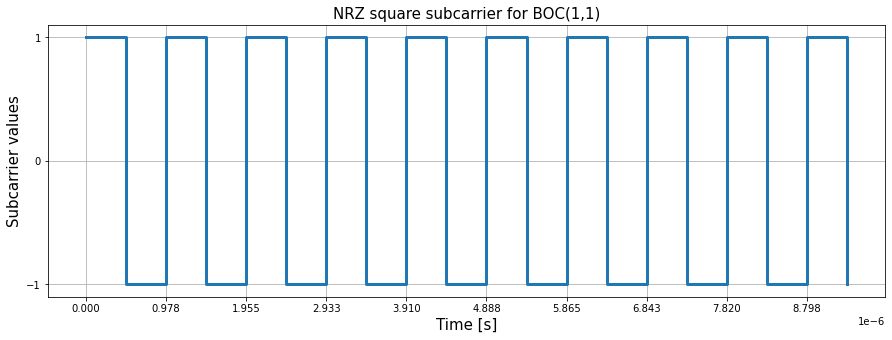

In [10]:
#Now we generate the BOC subcarrier, that is a square NRZ wave. The period of the waveform is given by Tc.

#The needed length of the subcarrier is 654720. This is because the spreaded sequence is composed of 327360
#symbols (data message is 80 symbols, and each symbol is spreaded with a PRN, that has 4092
#chips, so 80*4092 = 327360) and each symbol of the spreaded sequence (with duration of Tc) is kept constant for 2 
#samples of the subcarrier, therefore 327360*2 = 654720. 

Rc = settings['chipRate']   # chip rate
Tc = 1 / Rc     # chip period 

rep = 2 
s = np.array([1, -1])
subcarrier = np.tile(s, 327360) # we repeat the values 1 and -1 for 327360 times in order to have an array of 654720 elements                     

#now we plot the first 20 samples of the subcarrier
xticks = np.arange(0,10*Tc, Tc)
yticks = [-1, 0, 1]

t = np.arange(0, 10*Tc, Tc/2)
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.step(t, subcarrier[0:20], where='post', lw=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_title('NRZ square subcarrier for BOC(1,1)', fontsize=15)
ax.set_xlabel('Time [s]', fontsize=15)
ax.set_ylabel('Subcarrier values', fontsize=15)
ax.grid()

print("Subcarrier length:", len(subcarrier))  
print("First 20 samples of the subcarrier: ", subcarrier[0:20])

### NOW WE CONSIDER ONLY THE FIRST PACKET BUT LATER WE WILL NEED TO APPLY THE PROCEDURE TO ALL THE PACKETS INSIDE THE MATRIX

In [11]:
message = packets_matrix[0]
print("\n", message)


 [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0]


beginning m:  [0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 0]
After conversion m:  [  1 255   1 255 255   1   1   1   1   1   1   1   1   1   1 255   1   1
   1   1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1 255   1 255   1
 255 255 255   1   1   1 255 255   1 255   1 255   1 255 255   1   1   1
 255 255   1   1   1   1   1   1]


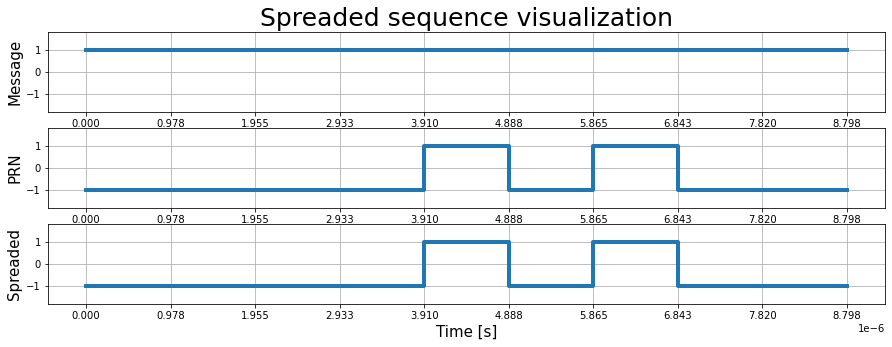

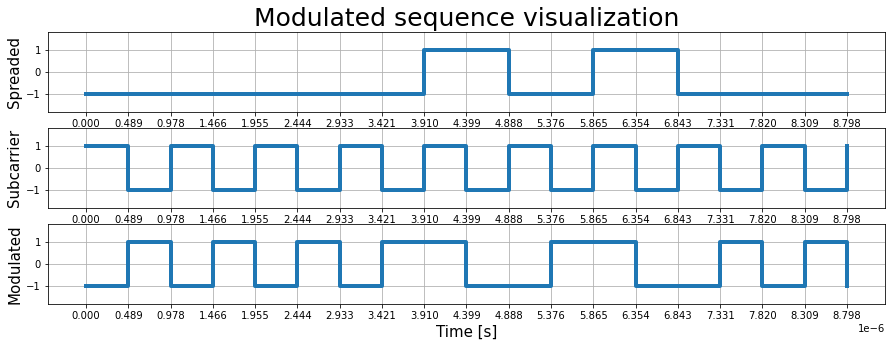

m:  [  1 255   1 255 255   1   1   1   1   1   1   1   1   1   1 255   1   1
   1   1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1 255   1 255   1
 255 255 255   1   1   1 255 255   1 255   1 255   1 255 255   1   1   1
 255 255   1   1   1   1   1   1]

Modulated message:
 [-1.  1. -1. ...  1.  1. -1.]
[[  1 255   1 255 255   1   1   1   1   1   1   1   1   1   1 255   1   1
    1   1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255   1
    1   1   1   1   1   1   1   1   1   1   1   1   1   1 255   1 255   1
  255 255 255   1   1   1 255 255   1 255   1 255   1 255 255   1   1   1
  255 255   1   1   1   1   1   1]
 [  0   1   0   1   1   0   0   0   0   0   0   0   0   0   0   1   0   0
    0   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   1   0
    1   1   1   1   1   1   0   0   0   0   0   1   0   1   0   1 

In [12]:
modulated = boc(message, subcarrier, settings["bitRate"], settings["chipRate"], settings['SV_PRN_ID'], np.array(e1bmodifiedcopy['Modified']), True)
print("\nModulated message:\n", modulated)

print(packets_matrix)

## SAMPLING OF THE SIGNAL

The following step consists in sampling the signal. The sampling frequency, contained in the settings.ini file, is set to 4.092 MHz. As explained in the report